## The affairs dataset

**This notebook was inspired by a lesson of Jose Portilla in his course Python for Data Analysis and Visualisation in Udemy.**

The affairs dataset is included in the python statsmodels package. The data comes from a 1974 survey of women by Redbook magazine. Married women were asked if they have had extramarital affairs. The results of the original study were published in:

Fair, Ray. 1978. “A Theory of Extramarital Affairs,” Journal of Political Economy, February, 45-61.

================================================

**Data information:**
Number of observations: 6366
Number of variables: 9
Variable name definitions:

    rate_marriage   : How rate marriage, 1 = very poor, 2 = poor, 3 = fair,
                    4 = good, 5 = very good
    age             : Age
    yrs_married     : No. years married. Interval approximations. See
                    original paper for detailed explanation.
    children        : No. children
    religious       : How relgious, 1 = not, 2 = mildly, 3 = fairly,
                    4 = strongly
    educ            : Level of education, 9 = grade school, 12 = high
                    school, 14 = some college, 16 = college graduate,
                    17 = some graduate school, 20 = advanced degree
    occupation      : 1 = student, 2 = farming, agriculture; semi-skilled,
                    or unskilled worker; 3 = white-colloar; 4 = teacher
                    counselor social worker, nurse; artist, writers;
                    technician, skilled worker, 5 = managerial,
                    administrative, business, 6 = professional with
                    advanced degree
    occupation_husb : Husband's occupation. Same as occupation.
    affairs         : measure of time spent in extramarital affairs

In [181]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.lda import LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

import statsmodels.api as sm

In [182]:
# Method to load statsmodels datasets into pandas
affairs = sm.datasets.fair.load_pandas().data
affairs.head(3)

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3,32,9.0,3,3,17,2,5,0.111111
1,3,27,13.0,3,1,14,3,4,3.230769
2,4,22,2.5,0,1,16,3,5,1.400000


Occupation and husband occupation are categorical variables, each number denotes a type of occupation. The variables religious, education and rate_married, although numeric, the scale is subjective to the person that designed the survey. In principle, we could assume a linear regression between 1: non religious and 4: strongly religious, but the truth is, these numbers are somewhat arbitrary. For the first model, I will treat them as numeric variables. 

First step will be to make a categorical variable "had_affair" indicating whether a woman had had an affair. We consider a positive when the woman mentions any time spent with someone other than her partner (affairs > 0)

Second step will be to make some exploratory data analysis and see how these variables relate to the rate of affairs among women.

Third, I will transform the categorical variables occupation and husband occupation to dummy variables.

### Preparation of the label: Had_Affair

In [183]:
# Function returns 1 if women had more than 0 time spent on affairs with someone else
def had_affair(x):
    if x == 0:
        return 0
    else:
        return 1
    
affairs['had_affair'] = affairs['affairs'].apply(had_affair)

# remove old affair column
affairs.drop('affairs', axis = 1, inplace = True)

affairs.head(2)

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,had_affair
0,3,32,9,3,3,17,2,5,1
1,3,27,13,3,1,14,3,4,1


### Exploratory data analysis

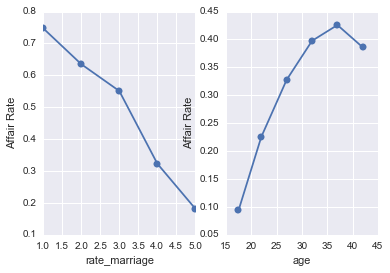

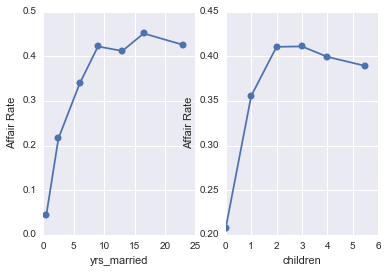

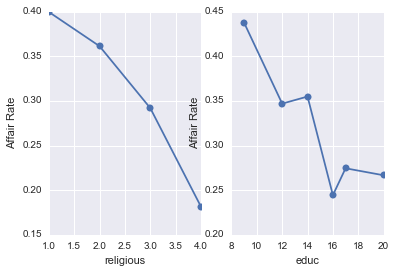

In [184]:
for i in range(0,6,2):
    # make intermediate df with mean of affairs per group
    temp = affairs.groupby(affairs.columns[i]).mean()
    temp2 = affairs.groupby(affairs.columns[i+1]).mean()
    
    f, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(temp.index, temp.had_affair, '-o')
    ax1.set_xlabel(affairs.columns[i])
    ax1.set_ylabel('Affair Rate')
    
    ax2.plot(temp2.index, temp2.had_affair, '-o')
    ax2.set_xlabel(affairs.columns[i+1])
    ax2.set_ylabel('Affair Rate')

According to this study/survey, the desire for affairs, or the time a woman spends with someone other than her partner, decreases if the marriage is a good one or if the woman is religious, or highly educated. On the other hand, older women, with several years in their marriage and with 1 or more children tend to have more affairs. Interesting if we were to believe...

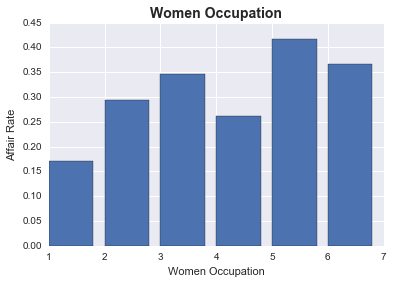

In [185]:
# plot affair rate vs occupation
temp = affairs.groupby(affairs.occupation).mean()
plt.bar(temp.index, temp.had_affair)
plt.title('Women Occupation', size = 14, fontweight = 'bold')
plt.ylabel('Affair Rate')
plt.xlabel('Women Occupation')

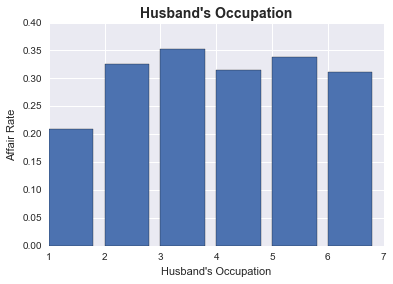

In [186]:
# plot affair rate vs Huband's occupation
temp = affairs.groupby(affairs.occupation_husb).mean()
plt.bar(temp.index, temp.had_affair)
plt.title("Husband's Occupation", size = 14, fontweight = 'bold')
plt.ylabel('Affair Rate')
plt.xlabel("Husband's Occupation")

The husband's occupation didn't seem to have an effect on women's affair, except for student husbands, whose partners had less affairs. Regarding the occupation of women, managerial or professional women (categories 6 and 7) seemed to be more prone to having affairs.

## Transformation of categorical variables: occupation

In [187]:
# create dummies
occ_dummies = pd.get_dummies(affairs.occupation)
husb_occ_dummies = pd.get_dummies(affairs.occupation_husb)

# Create column names for the new DataFrames
occ_dummies.columns = ['occ1','occ2','occ3','occ4','occ5','occ6']
husb_occ_dummies.columns = ['hocc1','hocc2','hocc3','hocc4','hocc5','hocc6']

# Drop first categorical from each dummy dataframe, as it can be inferred from the remaining ones
occ_dummies.drop('occ1', axis = 1, inplace = True)
husb_occ_dummies.drop('hocc1', axis = 1, inplace = True)

# Remove from the original dataset
affairs.drop(['occupation', 'occupation_husb'], axis = 1, inplace = True)

# concatenate all 3 dataframes
affairs = pd.concat([affairs, occ_dummies, husb_occ_dummies], axis = 1)
affairs.head()

,rate_marriage,age,yrs_married,children,religious,educ,had_affair,occ2,occ3,occ4,occ5,occ6,hocc2,hocc3,hocc4,hocc5,hocc6
0,3,32,9.0,3,3,17,1,1,0,0,0,0,0,0,0,1,0
1,3,27,13.0,3,1,14,1,0,1,0,0,0,0,0,1,0,0
2,4,22,2.5,0,1,16,1,0,1,0,0,0,0,0,0,1,0
3,4,37,16.5,4,3,16,1,0,0,0,1,0,0,0,0,1,0
4,5,27,9.0,1,1,14,1,0,1,0,0,0,0,0,1,0,0


### Model building

In [188]:
# generate X and Y for preditions
Y = np.ravel(affairs.had_affair)  # to flatten array
X = affairs.drop('had_affair', axis = 1)

In [189]:
# separate train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=1)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((4456, 16), (1910, 16), (4456,), (1910,))

In [190]:
# Determine the baseline guess (predicting the majority: not affair)
1-np.mean(Y)

0.67750549795790138

In [191]:
# Logistic Regression Model

logReg = LogisticRegression()  # make the model object
logReg.fit(X_train, Y_train)   # fit to the training set

predicted = logReg.predict(X_test)         # predict affairs on test set
metrics.accuracy_score(Y_test,predicted)   # check accuracy

0.7335078534031414

The accuracy is better than the baseline, so the logistic regression offers some advantage to make predictions.

In [192]:
def confusion_mtx(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm.columns.name = 'Predicted label'
    cm.index.name = 'True label'
    error_rate = (y_pred != y_test).mean()
    print('error rate: %.2f' % error_rate)
    return cm

In [193]:
confusion_mtx(Y_test, predicted)

error rate: 0.27


Predicted label,0,1
True label,,
0,1171,128
1,381,230


From the confusion matrix we see that the logistic regression makes a fare number of false positive and false negative mistakes, with an error rate of 27%.

In [194]:
# Feature selection
model_selFeat = SelectFromModel(logReg, prefit=True)
X_train_selFeat = model_selFeat.transform(X_train)
X_train_selFeat.shape

(4456, 7)

In [195]:
# select same features in test set
X_test_selFeat = model_selFeat.transform(X_test)
X_test_selFeat.shape

(1910, 7)

In [196]:
# re fit the logistic regression with the 7 features only
logReg_selFeat = LogisticRegression()
logReg_selFeat.fit(X_train_selFeat, Y_train)

predicted = logReg_selFeat.predict(X_test_selFeat)         # predict affairs on test set
metrics.accuracy_score(Y_test,predicted)   # check accuracy

0.72617801047120423

We observe that using only 7 of the 16 original features, the model is able to achieve the same accuracy. So this is a good indicator that this is a better, i.e, simpler model. And it is less likely to overfit.

In [197]:
confusion_mtx(Y_test, predicted)

error rate: 0.27


Predicted label,0,1
True label,,
0,1199,100
1,423,188


We observe the same error rate (27%). This model is a bit more coservative, making less false positive mistakes and a few more false negative mistakes.

In [198]:
# which features were selected?

non_removedFeatures = model_selFeat.inverse_transform(X_train_selFeat)
non_removedFeatures = non_removedFeatures.sum(axis = 0)
non_removedFeatures[non_removedFeatures > 0 ] = 1

# make a dataframe with the features and whether they were selected (1)
coef_df = pd.DataFrame(X.columns)
coef_df.columns = ['Features']

coef_df['Coefficients'] = pd.Series(non_removedFeatures)
coef_df

,Features,Coefficients
0,rate_marriage,1
1,age,0
2,yrs_married,0
3,children,0
4,religious,1
5,educ,0
6,occ2,1
7,occ3,1
8,occ4,1
9,occ5,1


In [199]:
coeff_df = coef_df[coef_df.Coefficients == 1]
coeff_df['Coefficients'] = np.transpose(logReg_selFeat.coef_)
coeff_df

,Features,Coefficients
0,rate_marriage,-0.715774
4,religious,-0.274074
6,occ2,0.389347
7,occ3,0.772334
8,occ4,0.483009
9,occ5,1.176870
10,occ6,0.888754


Above the features that were important for the logistic regression and the coefficients determined for the equation.

Let's see if we can improve the accuracy by building a linear discriminant analysis model.

### Linear Discriminant Analysis (LDA)

In [200]:
lda_model = LDA()   # make model object
lda_model.fit(X_train, Y_train)  # fit to train set

predicted = logReg.predict(X_test)         # predict affairs on test set
metrics.accuracy_score(Y_test,predicted)   # determine accuracy

0.7335078534031414

In [201]:
confusion_mtx(Y_test, predicted)

error rate: 0.27


Predicted label,0,1
True label,,
0,1171,128
1,381,230


No improvement with this model. Let's try a KNN (K nearest neighbors) model.

### KNN model

In [202]:
for neighbour in range(1,16,2):
    knn_model = KNeighborsClassifier(n_neighbors = neighbour)
    knn_model.fit(X_train, Y_train)
    predicted = knn_model.predict(X_test)
    print(metrics.accuracy_score(Y_test, predicted))

0.640837696335
0.69109947644
0.695287958115
0.701047120419
0.704188481675
0.712565445026
0.710994764398
0.712041884817


In [203]:
for neighbour in range(1,16,2):
    knn_model = KNeighborsClassifier(n_neighbors = neighbour, weights = 'distance')
    knn_model.fit(X_train, Y_train)
    predicted = knn_model.predict(X_test)
    print(metrics.accuracy_score(Y_test, predicted))

0.640837696335
0.685863874346
0.686910994764
0.693717277487
0.698952879581
0.7
0.702617801047
0.701047120419


In [204]:
for neighbour in range(1,16,2):
    knn_model = KNeighborsClassifier(n_neighbors = neighbour, algorithm = 'ball_tree')
    knn_model.fit(X_train, Y_train)
    predicted = knn_model.predict(X_test)
    print(metrics.accuracy_score(Y_test, predicted))

0.639790575916
0.689005235602
0.695287958115
0.703141361257
0.703141361257
0.70942408377
0.711518324607
0.712565445026


The accuracy obtained with KNN was lower than with the linear models. Let's try random forests

### Random Forests

In [205]:
rf_model = RandomForestClassifier(n_estimators = 500)
rf_model.fit(X_train, Y_train)
predicted = rf_model.predict(X_test)
metrics.accuracy_score(Y_test, predicted)

0.69947643979057594

The accuracy is lower as well.

### Extreme gradient boosting

In [206]:
import xgboost as xgb

gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X_train, Y_train)
predicted = gbm.predict(X_test)
metrics.accuracy_score(Y_test, predicted)

0.73036649214659688

These model performs as well as the logistic regression. So I will conclude that the best model for this dataset, to predict if a woman has had an affair, is the logistic regression with 7 features as described above.

To improve the performance, I could try scaling the parameters. But I will leave this excersice as it is for now.